# Wine quality analysis
## Classification
We use multiclassification techniques to predict the quality of the wine. This is a classification problem because the target variable is qualitative.
## Regression
However, in this particular case, the qualitative response can be seen as a continuous target (quality is a number between 0 and 10), we also explore the data with linear regression techniques. 

#### Let's explore the data and evaluate which method gives us the lowest error on the test set!

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from tqdm import tqdm

from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE


from vars import colors

from evaluate import plot_roc_pr_curves, evaluate_cls
from preprocessing import create_sets, remove_outlier
from functional import add_cls_res

# Import the data
We have two datasets, but for a matter of time, **we'll run our analysis on white wines**. 

Feel free to use our full methodology:
- on red wine only
- on both wines with color as a feature.


In [2]:
# Making the result reproducible
RANDOM_STATE = 42

# We will store the results in a dataframe
rslt_col = ['method', 'dataset', 'pr_m', 'rec_m', 'f1_m', 'pr_w', 'rec_w', 'f1_w', 'auc', 'pr']
results_df = pd.DataFrame(columns=rslt_col)

# Target color
tgt_wine = 'white'

# Open files
wine_path = f'__data__/winequality-{tgt_wine}.csv'
wine_df = pd.read_csv(wine_path, delimiter=';')

# Process column name
wine_df = wine_df.rename(columns=lambda x: x.replace(' ', '_'))

tgt_col = ['quality']
feat_col = wine_df.columns[:-1]

display(wine_df.head())

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

# Overview of the data statistics

▶ There are no missing values.

▶ All features are quantitative. Some predictors seems to have outliers (maximum >> Q75). 

▶ There are 794 duplicated row. We keep them because it might me different wine tester. 


In [8]:
# Count total NaN at each column in a DataFrame 
print(" \nCount total NaN at each column in white wine DataFrame : \n\n", 
      wine_df.isnull().sum())
print(f' Number of duplicated rows: {wine_df.duplicated().sum()} among {len(wine_df)}.')

display(wine_df[wine_df.duplicated(keep=False)].head().sort_values(by='chlorides'))

 
Count total NaN at each column in white wine DataFrame : 

 fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
 Number of duplicated rows: 937 among 4898.


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

In [9]:
display(wine_df.describe().round(2))

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count        4898.00           4898.00      4898.00         4898.00   
mean            6.85              0.28         0.33            6.39   
std             0.84              0.10         0.12            5.07   
min             3.80              0.08         0.00            0.60   
25%             6.30              0.21         0.27            1.70   
50%             6.80              0.26         0.32            5.20   
75%             7.30              0.32         0.39            9.90   
max            14.20              1.10         1.66           65.80   

       chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density       pH  \
count    4898.00              4898.00               4898.00  4898.00  4898.00   
mean        0.05                35.31                138.36     0.99     3.19   
std         0.02                17.01                 42.50     0.00     0.15   
min         0.01                 2.00                  9.00     0.99     2.72   
25%         0.04                23.00                108.00     0.99     3.09   
50%         0.04                34.00                134.00     0.99     3.18   
75%         0.05                46.00                167.00     1.00     3.28   
max         0.35               289.00                440.00     1.04     3.82   

       sulphates  alcohol  quality  
count    4898.00  4898.00  4898.00  
mean        0.49    10.51     5.88  
std         0.11     1.23     0.89  
min         0.22     8.00     3.00  
25%         0.41     9.50     5.00  
50%         0.47    10.40     6.00  
75%         0.55    11.40     6.00  
max         1.08    14.20     9.00

# Distribution of the target
The target distribution seems normal (but we could double check it with tests such as Shapiro), so we can use statistical tools such as test-statistic to infer the certainty of the parameters of our model.

▶ Very low and high quality wines are rare.

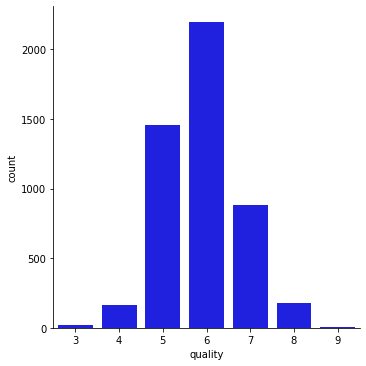

In [10]:
# Distribution of the target
sns.catplot(x='quality', data=wine_df, kind='count', color='b')

# Baseline
For white wines, the most frequent class (44% of the dataset) is 6 for white wine. 
We consider that a dummy classifier performance (predict all white wine as class 6) would have a average accuracy of 46.5%.

▶ So we need to achieve an **accuracy greater than 46.5%** to perform better than chance.  
▶ So we need to achieve a **weighted f1 score greater than 27.8%** to perform better than chance.  
▶ So we need to achieve a **macro f1 score greater than (avg(44.9,29,7,...,0.1)=)14.2%** to perform better than chance.  

In [11]:
print(wine_df['quality'].value_counts(normalize=True, dropna=False).round(3) * 100)

6    44.9
5    29.7
7    18.0
8     3.6
4     3.3
3     0.4
9     0.1
Name: quality, dtype: float64


# Visualization of the correlation 

We want to visualize **pair-wise correlations** of the different features, and the **strenght of the correlation**.


We use a **scatterplot** for visualize the correlations and the **correlation matrix** (standardized covariance matrice) to quantify them.

▶ We can observe: 

- Scatterplot:
    - Linear relationship between the target (_quality_) and some parameters (_alchohol, pH, fixed acidity and volatile acidity_). We will confirm them later. 
- Correlation matrix:
    - Multicollinearity between features (alchohol/ density or density/residual)

We will confirm these first observations with statistics!

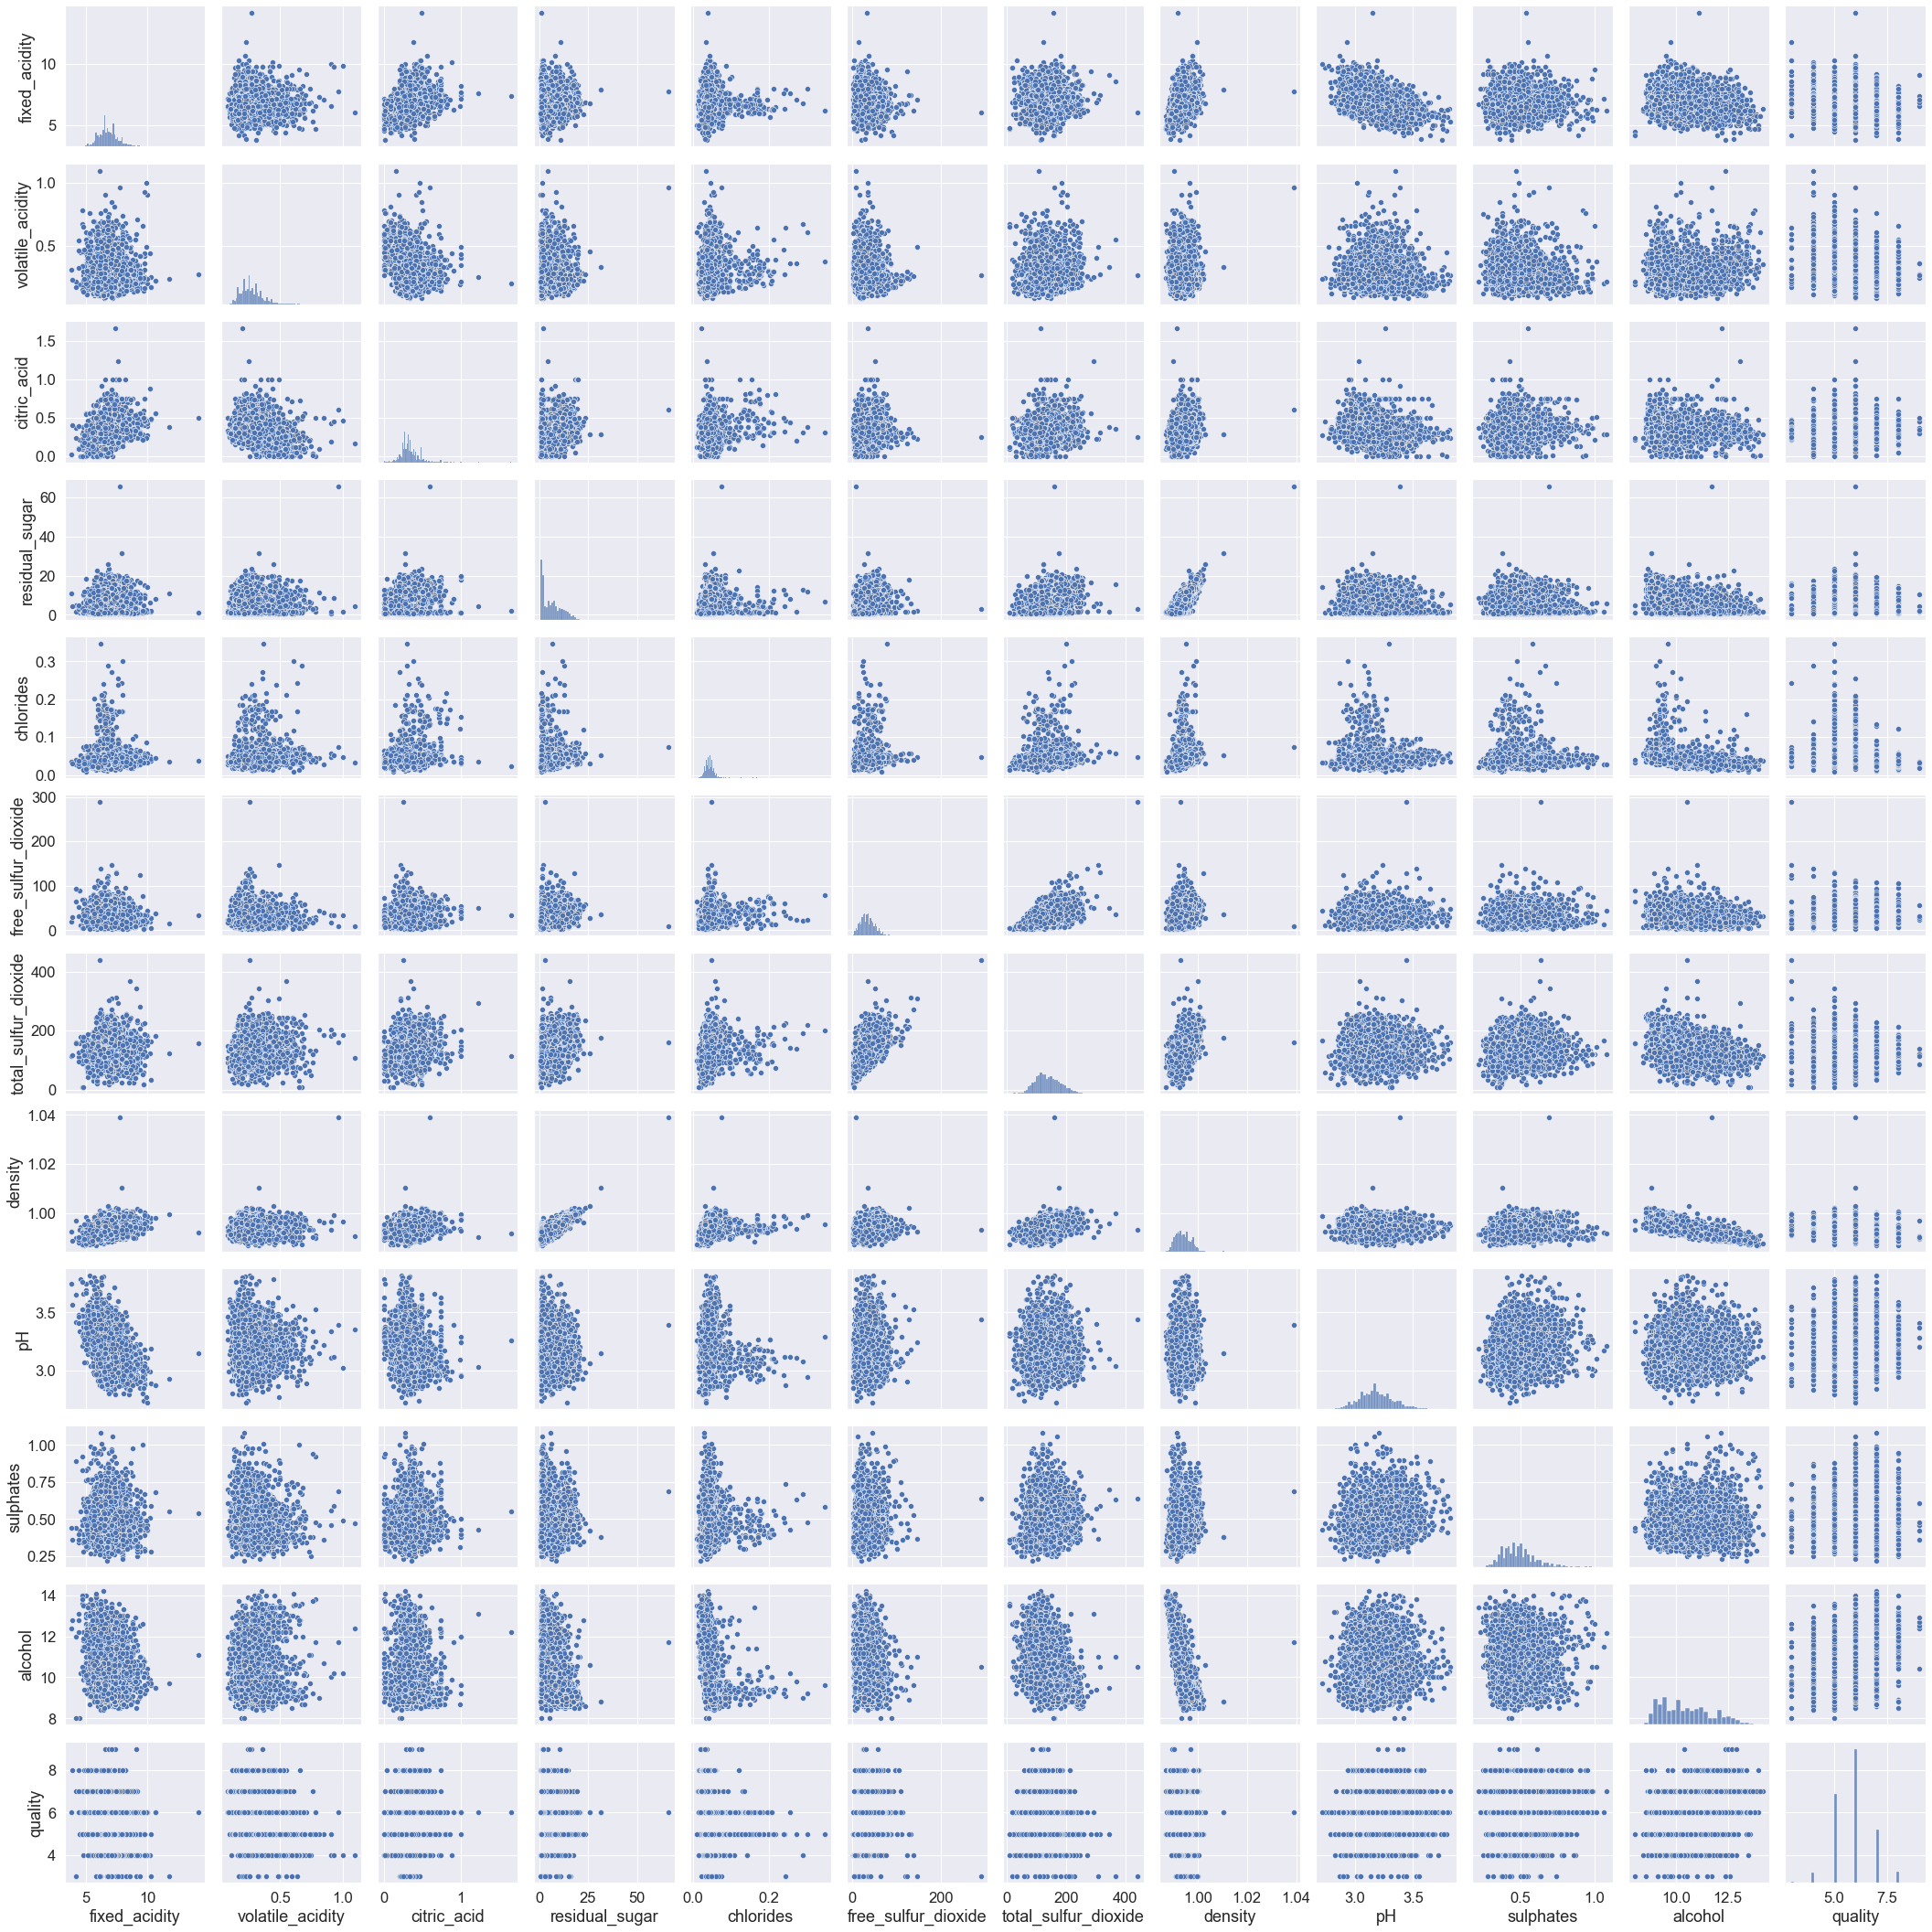

In [12]:
sns.set(font_scale=1.5) 

sns.pairplot(wine_df)
plt.show()
# Index(['citric acid', 'chlorides', 'total sulfur dioxide'], dtype='object')


# Correlation

 We check at correlation. When variables are correlated, the estimated regression coefficient of any one variable depends on which other predictor variable included in the model. 
 
 
Multi-collinearity does not directly change the prediction accuracy but:
- we cannot interpret the weights of the slope for linear regression as "one increase of predictors, increases the answer of..". 
- our prediction might be overfitted.

The highly correlated variable contributing the less for quality are:
- residual sugar
- free sulfure dioxide.

We remind them for later feature selection.

Text(0.5, 1.0, 'Correlation Heatmap')

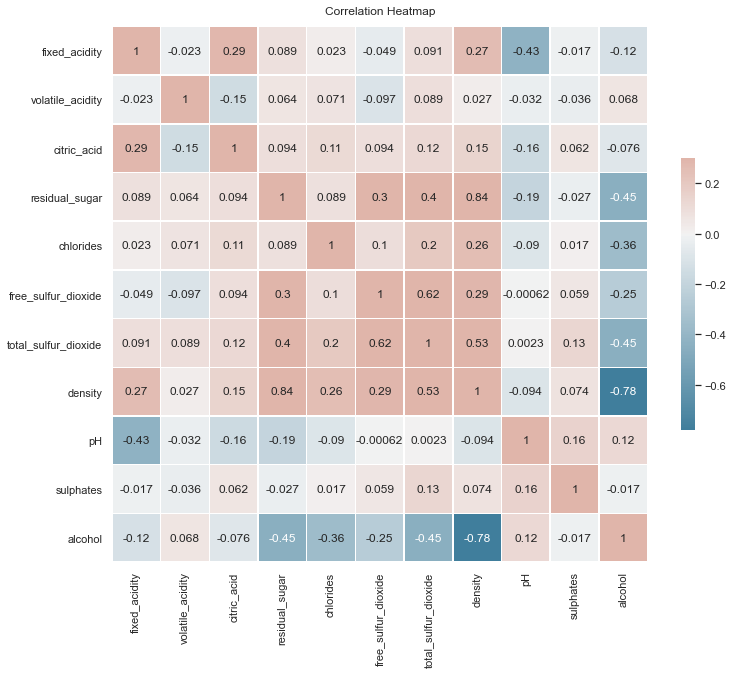

In [13]:
sns.set(font_scale=1) 

# 1, -1 is perfect positive, negative respectively correlation
# 0 is no correlation

# Compute correlation matrix
corr = wine_df[feat_col].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap and correct aspect ratio
heatmap = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# Distribution and outliers

## Distributions
▶ Distributions overlap among different quality for all predictors. 

▶ The mean of the distribution is flat, but for alcohol, density and pH.

▶ All features look approximatively normally distributed. We could run a QQplot and statistical test to confirm it. 

▶ **residual sugar** is skewed to the left (and will be even if we remove outliers). It is likely we remove him from the prediction model. 

▶ **alcohol** is slightly skewed as well, but has no outliers.

## Outliers

- all other features have outliers, mostly on higher values.

▶ With the rule "a predictor value is considered to be an outlier only if it is greater than Q3 + 1.5IQR", **we remove the outliers from the dataset**. From 4898 rows, we keep 4015 of them.



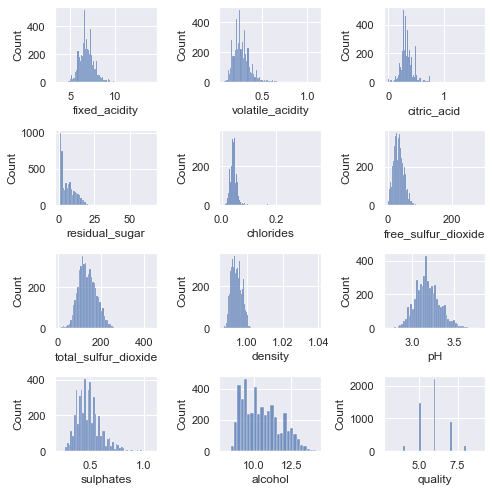

In [14]:
fig, axs = plt.subplots(4,3, figsize=(7,7))
axs = axs.flatten()
for i, feat in enumerate(wine_df.columns):
    sns.histplot(x=feat, ax=axs[i], data=wine_df)
plt.tight_layout()

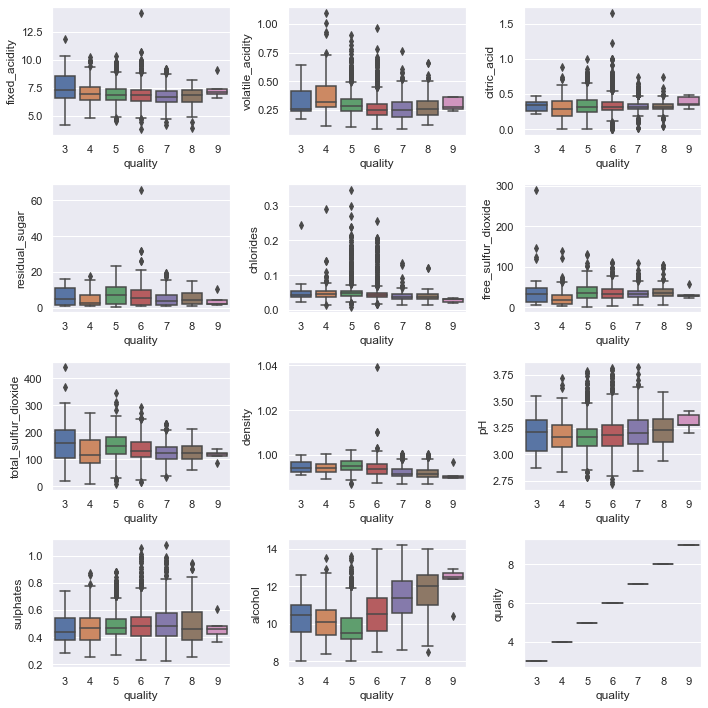

In [15]:
fig, axs = plt.subplots(4,3, figsize=(10,10))
axs = axs.flatten()
for i, feat in enumerate(wine_df.columns):
    sns.boxplot(y=feat, ax=axs[i], data=wine_df, x='quality')
plt.tight_layout()

# Data engineering

##### Removing outliers helps to see clearly the distribution

-> chlorides, free sulfur dioxide, density and alchohol are non flat mean now. 


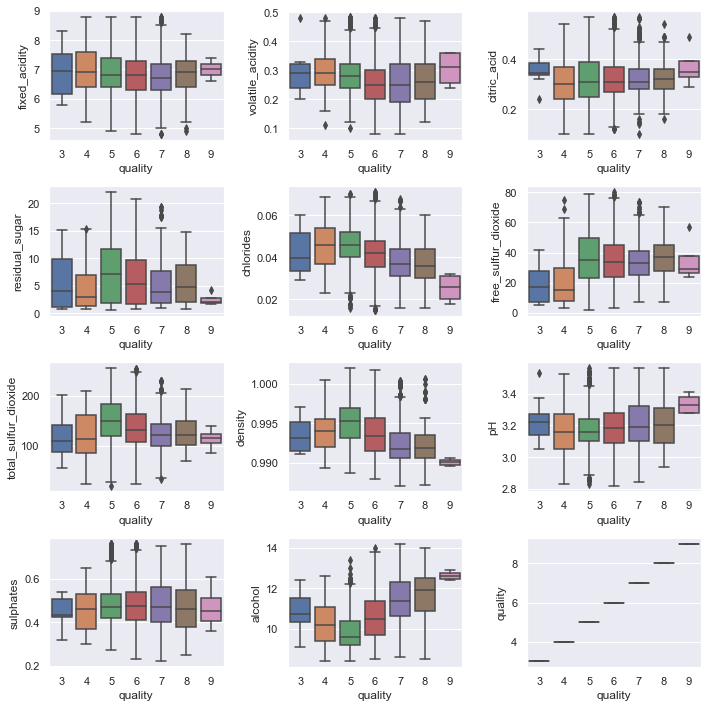

In [16]:
# We remove the outliers from our analysis
wine_df = remove_outlier(wine_df, feat_col)
fig, axs = plt.subplots(4,3, figsize=(10,10))
axs = axs.flatten()
for i, feat in enumerate(wine_df.columns):
    sns.boxplot(y=feat, ax=axs[i], data=wine_df, x='quality')
plt.tight_layout()

## Conclusion for EDA
#### Quality prediction will be challenging. The dataset is very imbalanced, the predictors are correlated and overlap for different quality. 
- alchohol and density are highly negatively correlated
- Multicollinearity exists between:
    - residual sugar and density
    - density and total sulfure dioxyde, 
    - free sulfure and total sulfure

#### Because of their high correlation with other features and low correlation with quality, we think about removing:
- free or total sulfure (later significance result will make us remove total sulfure)
- residual sugar.


# Preparing the datasets for prediction

We create train (70%), validation (15%) and test dataset (15%). 

The dataset is stratified to keep the original class distribution in all the sets. 

We standardize the features with a scaler.

In [17]:
significant_col = ['fixed_acidity', 'volatile_acidity', 'citric_acid',
       'chlorides', 'free_sulfur_dioxide', 'density',
        'sulphates', 'alcohol']

# Creation of train, val, test set from all feature dataset.
X_train_sc, X_val_sc, X_test_sc, y_train, y_val, y_test, scaler = create_sets(wine_df, feat_col, tgt_col)
X_train_sc_pre, X_val_sc_pre, X_test_sc_pre, y_train, y_val, y_test, scaler = create_sets(wine_df, significant_col, tgt_col)

Train shape: (2900, 11), validation shape: (512, 11), test shape: (603, 11)
Train shape: (2900, 8), validation shape: (512, 8), test shape: (603, 8)


## PCA


### We look for the number of components enough to explain 90% of the variance.

The elbow shape is very smooth, but **seven components** seem enough.

We could try LDA as well. 


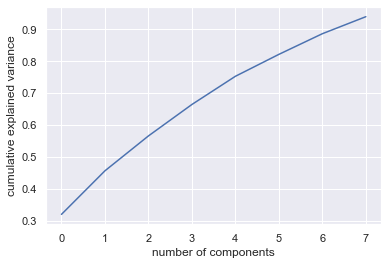

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9) 
results = pca.fit(X_train_sc) 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
X_train_pca = pca.transform(X_train_sc)
X_val_pca = pca.transform(X_val_sc)
X_test_pca = pca.transform(X_test_sc)

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


# Oversampling

We excessively oversample the minority class (1% to 50%).

In [19]:
# We oversample with smote algorithm
oversample = SMOTE(k_neighbors=2)
X_train_os, y_train_os = oversample.fit_resample(X_train_sc, y_train)

for i in np.unique(y_train):
    per_os = 100 * np.sum(np.array([y_train_os==i]).astype(np.int32))/ len(y_train_os)
    per = 100 * np.sum(np.array([y_train==i]).astype(np.int32))/ len(y_train)
    print(f'Class {i}, {per:.2f}% -> {per_os:.2f}')

    


Class 3, 0.21% -> 14.29
Class 4, 2.24% -> 14.29
Class 5, 27.55% -> 14.29
Class 6, 46.48% -> 14.29
Class 7, 19.83% -> 14.29
Class 8, 3.59% -> 14.29
Class 9, 0.10% -> 14.29


# Measuring linearity and significance

We use linear toolbox to check our first guesses. We want to know: Are the linear relationships between each feature and the target significant?

# I. Linear regression

We can predict our target continuously. Of course, we should not try to predict outside our input space.

### Takeaways:

▶ Our model is very biaised. The prediction error is almost constant between training and test, but unfortunately also high for both (~0.57). This model is too simple and there are some relationships which are not understood by the model.



In [20]:
# LR and check the statistical significance (since our tgt distribution is normal)
# Create linear regression object

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train_sc, y_train)
train_pred = np.rint(regr.predict(X_train_sc))

# Make predictions using the testing set
test_pred = np.rint(regr.predict(X_test_sc))

print(f'R^2 score is {regr.score(X_train_sc, y_train):.2f}')

print('Classification result on training:')
print(classification_report(y_train, train_pred))
print('Classification result on test:')
print(classification_report(y_test, test_pred))

R^2 score is 0.26
Classification result on training:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        65
           5       0.58      0.32      0.41       799
           6       0.51      0.81      0.63      1348
           7       0.46      0.26      0.33       575
           8       0.00      0.00      0.00       104
           9       0.00      0.00      0.00         3

    accuracy                           0.51      2900
   macro avg       0.22      0.20      0.20      2900
weighted avg       0.49      0.51      0.47      2900

Classification result on test:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        13
           5       0.57      0.24      0.34       166
           6       0.49      0.80      0.61       280
           7       0.43      0.27      0.33     

/Users/bettyld/opt/anaconda3/envs/netsmile2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bettyld/opt/anaconda3/envs/netsmile2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bettyld/opt/anaconda3/envs/netsmile2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# A trial on significance..

Let's assume we can run significance test after checking the normality/ making the normality of the distributions.

We identify non significant predictors by their high p-values and their low coefficients. 

We try to remove non significant predictor but the $R^2$ error does not change.

Due to poor performances, we will stop linear regression and focus on multiclassification.


In [21]:
# Target variable is normally distributed
# P-value confirms the existence of a linear relationship between the variable and the target.
# Nonetheless, the 3rd, 5th and 7th columnm seems to have no linear relatioship
import statsmodels.api as sm

X2 = scaler.fit_transform(wine_df[feat_col])
X2 = pd.DataFrame(X2, columns=feat_col, index=wine_df.index)
y = wine_df[tgt_col]
X2 = sm.add_constant(X2)
mreg2 = sm.OLS(y, X2).fit()
print(mreg2.summary())


                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     121.8
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          3.11e-241
Time:                        23:46:35   Log-Likelihood:                -4489.2
No. Observations:                4015   AIC:                             9002.
Df Residuals:                    4003   BIC:                             9078.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.9479 

## Significance and feature selection
Removing residual sugar improves the $R^2$ score but removing total sulfure and citric acid does not change it. 
Because we remember total sulfure was correlated with free sulfure, we decide that we should remove:
- residual sugar
- total sulfure.
- citric acid. 
- pH

In [22]:
# We remove non significant total sulfure, citric acid from significance and residual sugar from EDA. 
# The r^2 value does not change much. We will keep these predictors for now. 

# When we remove total citric acide, total sulfure, then pH becomes non significant so we remove it as well. 
significant_col = ['fixed_acidity', 'volatile_acidity', 'citric_acid',
       'chlorides', 'free_sulfur_dioxide', 'density',
        'sulphates', 'alcohol']

X2 = scaler.fit_transform(wine_df[significant_col])
X2 = pd.DataFrame(X2, columns=significant_col, index=wine_df.index)
y = wine_df[tgt_col]
X2 = sm.add_constant(X2)
mreg2 = sm.OLS(y, X2).fit()
print(mreg2.summary())


                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     153.1
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          1.48e-225
Time:                        23:46:35   Log-Likelihood:                -4533.2
No. Observations:                4015   AIC:                             9084.
Df Residuals:                    4006   BIC:                             9141.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.9479    

### Results
▶ The linear model can only explain 26% of the variance of the test dataset. It is too much of unknown left.

▶ Accuracy (49%) and macro F1 score (~20%) are slightly better than dummy classifier.

▶ We achieve the best test accuracy by taking into account the 11 predictors.


In [23]:
# Append results for linear regression fit on each dataset 
res_list = add_cls_res('linreg', regr, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)

results_df = results_df.append(res_list)
print('Linear regression done')

--> All
Training acc: 0.26
Test acc: 0.23
AUC non available
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        13
           5       0.57      0.24      0.34       166
           6       0.49      0.80      0.61       280
           7       0.43      0.27      0.33       120
           8       1.00      0.00      0.00        22
           9       1.00      0.00      0.00         1

    accuracy                           0.49       603
   macro avg       0.78      0.19      0.18       603
weighted avg       0.53      0.49      0.44       603

--> Oversample
Training acc: 0.51
Test acc: -0.73
AUC non available
              precision    recall  f1-score   support

         2.0       0.00      1.00      0.00         0
         3.0       0.00      0.00      0.00         1
         4.0       0.04      0.15      0.06        13
         5.0       0.47      0.37      0.41       166
    

# II. Multiclass classification

We will try and compare several models on test dataset. 

##  1. Logistic regression 

We compute OneVersusRest binary multiclassification.

▶ Accuracy on test dataset is 52% with hyperparameters: C=0.1. But macro f1 score is still bad (~18%)


In [24]:
# Creating weights inversely proportionate for objective functions
dict_weight = {}
for i in np.unique(y_train):
    per = 100 * np.sum(np.array([y_train==i]).astype(np.int32))/ len(y_train)
    dict_weight[i] = 100/ np.sum(np.array([y_train==i]).astype(np.int32))
    print(f'Class {i}, {per:.2f}% -> {dict_weight[i]:.2f}')



Class 3, 0.21% -> 16.67
Class 4, 2.24% -> 1.54
Class 5, 27.55% -> 0.13
Class 6, 46.48% -> 0.07
Class 7, 19.83% -> 0.17
Class 8, 3.59% -> 0.96
Class 9, 0.10% -> 33.33


### Feature selection

###### We use L1 regularization to remove easily the predictors with the less effect on the accuracy. 

We can observe the weights for each features in Logistic Regression.


##### Results

When we consider all the features, the weight associated with residual sugar and pH are almost null (they are actually removed from the feature selection). 

When we consider only the pre-selected subset of features, sulfure features' weight are almost null.

**The most important features relatively to the weights are not the same than Linear Regression. pH and total sulfure have very important weights.** 

### Hyperparameter selection

The best validation accuracy for a small C (inverse of regularization strenght) is obtained with C=0.01.


/Users/bettyld/opt/anaconda3/envs/netsmile2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


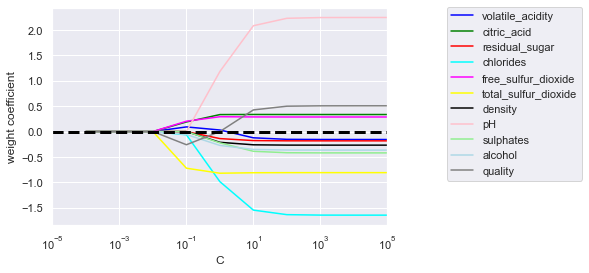

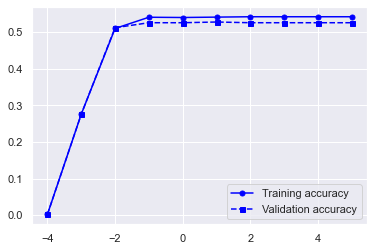

In [25]:
fig, ax = plt.subplots()


param_range = np.arange(-4., 6.)
weights, params, train_acc, val_acc = [], [], [], []
for c in param_range:
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', multi_class='ovr', random_state=RANDOM_STATE)
    lr.fit(X_train_sc, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    train_acc.append(lr.score(X_train_sc, y_train))
    val_acc.append(lr.score(X_val_sc, y_val))

# Weight curve
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=wine_df.columns[column + 1],
             color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()


# Validation curve
plt.plot(param_range, train_acc, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')
plt.plot(param_range, val_acc, 
         color='blue', linestyle='--', 
         marker='s',
         markersize=5, label='Validation accuracy')
plt.legend()

### Weights

When we add the weighted dictionnary, the minority classes are detected and macro average jumps to 18% to 25%.
But class weights decrease overall performances. We won't use it.

In [26]:
from sklearn.linear_model import LogisticRegression
from evaluate import evaluate_cls

# C is hyperparameter to control the regularization effect
# increase, decreasing it will make the regularization strong, weaker respectively
lr = LogisticRegression(penalty='l1', C=10.**1, solver='liblinear', multi_class='ovr', random_state=RANDOM_STATE,
                       )# class_weight=dict_weight)
lr.fit(X_train_sc, y_train)

evaluate_cls(lr, np.vstack([X_train_sc, X_val_sc]), np.concatenate([y_train, y_val]), X_test_sc, y_test, verbose='minimal')

Training acc: 0.54
Test acc: 0.50
Roc AUC score 0.76
Precision-Recall AUC score 0.25
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        13
           5       0.59      0.41      0.48       166
           6       0.50      0.79      0.61       280
           7       0.33      0.12      0.17       120
           8       1.00      0.00      0.00        22
           9       1.00      0.00      0.00         1

    accuracy                           0.50       603
   macro avg       0.77      0.19      0.18       603
weighted avg       0.52      0.50      0.45       603



[0.7746279326704361,
 0.18845176624866816,
 0.1811993598901827,
 0.5216064992513225,
 0.5041459369817579,
 0.45161201852886323,
 0.7563570735747274,
 0.2505776667867673]

### All predictors
With all predictors and C1=10, we achieve test accuracy of 50%. Training and test accuracy are almost the same. As we would expect from l1 regularization, the model is biased but not overfitted. We achieve 52% accuracy but actually 22% PR score and weighted f1 of 45% (which falls to 18% when we add weighted dictionnary).

### Oversampling


### Pre-selected
When we take the previously selected features only and C1=0.2. <br> 
This is because in average the f1 score is 
<br> 3/7 classes only are detected in total. 
Even when we remove only residual sugar then pH weight become very small and only majority classes are detected

### Conclusion
We remove 'residual sugar' and 'pH' from feature subset. We could investigate further which predictor could we remove with the less decrease of performance. But we won't do it because the overall performance of LR are low. 

In [27]:
# Append results for linear regression fit on each dataset 
res_list = add_cls_res('lr', lr, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)

results_df = results_df.append(res_list)
print('Logistic regression done')

--> All
Training acc: 0.54
Test acc: 0.50
Roc AUC score 0.76
Precision-Recall AUC score 0.25
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        13
           5       0.59      0.41      0.48       166
           6       0.50      0.79      0.61       280
           7       0.33      0.12      0.17       120
           8       1.00      0.00      0.00        22
           9       1.00      0.00      0.00         1

    accuracy                           0.50       603
   macro avg       0.77      0.19      0.18       603
weighted avg       0.52      0.50      0.45       603

--> Oversample
Training acc: 0.51
Test acc: 0.24
Roc AUC score 0.72
Precision-Recall AUC score 0.22
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.05      0.31      0.09        13
           5       0.48      0.42      0.45    

# Decision Tree

We also run DecisionTreeClassifier. 

## Hyperparameters search
Best hyperparameters are 'entropy' and a max depth of 25.

The classifier overfits but outperforms our previous classifiers.

## Results
Test accuracy is ~60% with DecisionTreeClassifier and f1 score 38% in macro, 60% weighted.


In [28]:
# cross validation with Decision Tree
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
                  param_grid=[{'max_depth': list(range(15,70, 5)), 'criterion': ['entropy', 'gini']}],
                  scoring='accuracy',
                  cv=5)
gs.fit(X_train_sc, y_train)

print('Best parameters are:', gs.best_params_)

dtc = DecisionTreeClassifier(**gs.best_params_)
dtc.fit(X_train_sc, y_train)
evaluate_cls(dtc, np.vstack([X_train_sc, X_val_sc]), np.concatenate([y_train, y_val]), X_test_sc, y_test, verbose='minimal')

/Users/bettyld/opt/anaconda3/envs/netsmile2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best parameters are: {'criterion': 'entropy', 'max_depth': 30}
Training acc: 0.94
Test acc: 0.59
Roc AUC score 0.64
Precision-Recall AUC score 0.47
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.33      0.38      0.36        13
           5       0.63      0.60      0.61       166
           6       0.61      0.62      0.62       280
           7       0.54      0.54      0.54       120
           8       0.43      0.45      0.44        22
           9       1.00      0.00      0.00         1

    accuracy                           0.59       603
   macro avg       0.51      0.37      0.37       603
weighted avg       0.59      0.59      0.59       603



[0.5081534356641522,
 0.3712345170606789,
 0.36788315387826426,
 0.5916981763605961,
 0.5854063018242123,
 0.5874977222702058,
 0.6404391364381636,
 0.46930781194640037]

# Random Forest

We use a random forest classifier. Random forest uses ensemble model to gather votes from different DecisionTree and assign to each sample the class with most votes.

## Results

▶ Random forest achieves the highest precision, recall and f1-score so far 69% and 67, 66%.

▶ Only extreme class 3 and 9 are not detected. 

▶ AUC score on test dataset is 84% and PR score 49%.

Training acc: 1.00
Test acc: 0.68
Roc AUC score 0.81
Precision-Recall AUC score 0.49
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.80      0.31      0.44        13
           5       0.79      0.60      0.68       166
           6       0.64      0.83      0.72       280
           7       0.64      0.54      0.59       120
           8       1.00      0.27      0.43        22
           9       1.00      0.00      0.00         1

    accuracy                           0.68       603
   macro avg       0.84      0.37      0.41       603
weighted avg       0.70      0.68      0.67       603



/Users/bettyld/opt/anaconda3/envs/netsmile2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Cross validation score with roc_auc 0.66
--Confusion Matrix--


[0.8387251173355262,
 0.36523410611190305,
 0.40963535832298,
 0.6991163406639623,
 0.6766169154228856,
 0.6661921398962171,
 0.8066455489840271,
 0.4944435245367183]

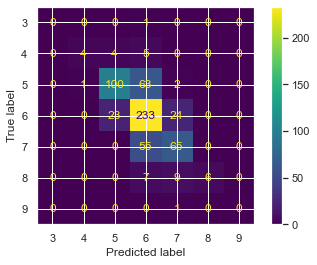

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Feature importance given the average impurity decrease in the 500 decision trees. 
forest = RandomForestClassifier(n_estimators=1000,
                                random_state=RANDOM_STATE)
forest.fit(X_train_sc, y_train)
evaluate_cls(forest, X_train_sc, y_train, X_test_sc, y_test, verbose='maximal')


In [30]:
# Append results for random forest fit on each dataset 
res_list = add_cls_res('rf', forest, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)

results_df = results_df.append(res_list)
print('Random forest done')

--> All
Training acc: 1.00
Test acc: 0.68
Roc AUC score 0.81
Precision-Recall AUC score 0.49
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.80      0.31      0.44        13
           5       0.79      0.60      0.68       166
           6       0.64      0.83      0.72       280
           7       0.64      0.54      0.59       120
           8       1.00      0.27      0.43        22
           9       1.00      0.00      0.00         1

    accuracy                           0.68       603
   macro avg       0.84      0.37      0.41       603
weighted avg       0.70      0.68      0.67       603

--> Oversample
Training acc: 1.00
Test acc: 0.66
Roc AUC score 0.81
Precision-Recall AUC score 0.47
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.42      0.38      0.40        13
           5       0.72      0.68      0.70    

## Hyper parameter search

1000 decision trees give the best result.

100%|██████████| 14/14 [00:48<00:00,  3.46s/it]


Text(0.5, 1.0, 'F1 score for different nb estimators')

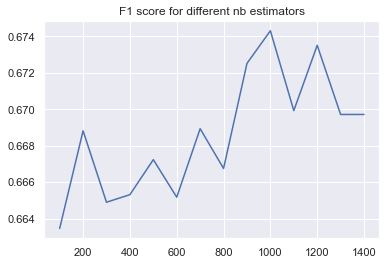

In [40]:
from sklearn.metrics import f1_score
f1_list = {}
for _ in range(5):
    for i in tqdm(range(100, 1500, 100)):
        forest = RandomForestClassifier(n_estimators=i,
                                        random_state=RANDOM_STATE)
        forest.fit(X_train_sc, y_train)
        if i in f1_list:
            f1_list[i].append(f1_score(y_val, forest.predict(X_val_sc), average='weighted'))
        else: 
            f1_list[i] = [f1_score(y_val, forest.predict(X_val_sc), average='weighted')]
        
for t in f1_list:
    f1_list[t] = np.mean(f1_list[t])
plt.plot(list(f1_list.keys()), list(f1_list.values()))
plt.title('F1 score for different nb estimators')

# Feature importance with RandomForest

▶ The features with less importance we previously found ('citric_acid' and 'pH') are again at the bottom the of feature hierarchy. 'Sulfate' and 'fixed acidity' are added as feature of less importance.

▶ Alchohol and density are contributing the most.

▶ So far Linear Regression, Logistic Regression and Random Forest had a different hierarchy of features. 

 1) alcohol                        0.115843
 2) density                        0.104133
 3) volatile_acidity               0.094535
 4) free_sulfur_dioxide            0.092243
 5) total_sulfur_dioxide           0.091912
 6) residual_sugar                 0.091206
 7) chlorides                      0.087339
 8) pH                             0.086522
 9) sulphates                      0.081231
10) citric_acid                    0.080212
11) fixed_acidity                  0.074825


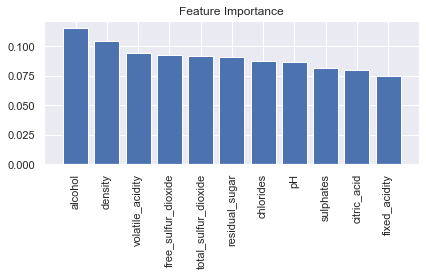

In [41]:
# we save feature importance
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train_sc.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_col[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train_sc.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train_sc.shape[1]), 
           feat_col[indices], rotation=90)
plt.xlim([-1, X_train_sc.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

# ROC and PR curves
We can visualize the poor prediction results on minority classes.

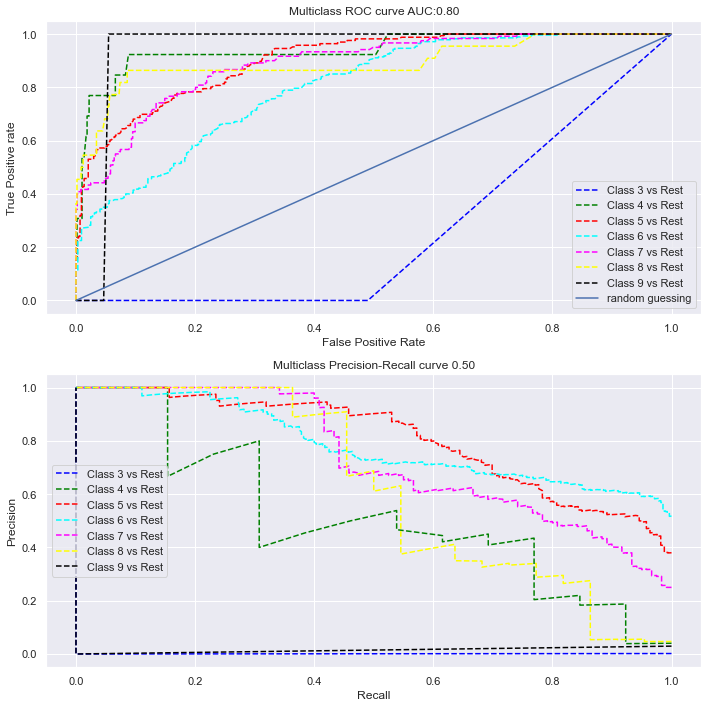

In [44]:
plot_roc_pr_curves(forest, X_test_sc, y_test)

# SVM

Support Vector Machine are effective in high dimension space.

They do OneVersusOne multiclass classification.
We find the best hyperparameters (out of this notebook):

Results are disappointing for linear SVC, the results only detect two classes.

When we use SMOTE oversampling method, we can detect 6 classes but overall performances are still very low.

Start GridSearch among 28 possibilities
Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


param {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Training acc: 0.44
Test acc: 0.43
AUC non available
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        13
           5       0.58      0.41      0.48       166
           6       0.50      0.86      0.63       280
           7       1.00      0.00      0.00       120
           8       1.00      0.00      0.00        22
           9       1.00      0.00      0.00         1

    accuracy                           0.51       603
   macro avg       0.87      0.18      0.16       603
weighted avg       0.65      0.51      0.43       603

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Cross validation score with roc_auc 0.52
--Confusion Matrix--


[0.8684484240039796,
 0.18198918121465454,
 0.1589170224179312,
 0.6515796033024704,
 0.5140961857379768,
 0.4256930541332095,
 None,
 None]

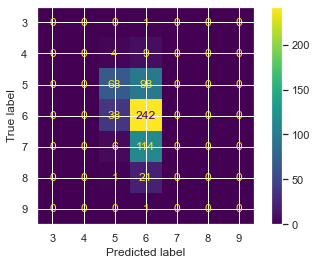

In [45]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, make_scorer

# We could try 'rbf' and 'poly' kernel but the CV would not end on my local computer.
labels = np.unique(wine_df[tgt_col].values)
parameters = {
    'kernel': ['linear'],
    'C': [0.001, 0.01, 0.1, 1, 2, 5, 10],
    'gamma': [0.01, 0.1, 0.5, 1]
}
grid_parameters = list(ParameterGrid(parameters))
print('Start GridSearch among', len(grid_parameters), 'possibilities')
svc = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose=1, scoring=make_scorer(f1_score, average='weighted'))
svc.fit(X_train_sc, y_train)
print('param', svc.best_params_)

# Normal dataset
evaluate_cls(svc, X_train_sc, y_train, X_test_sc, y_test, verbose='maximal')


In [46]:
# Append results for SVM fit on each dataset 
res_list = add_cls_res('svm', svc, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)

results_df = results_df.append(res_list)
print('SVM done')

--> All
Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training acc: 0.44
Test acc: 0.43
AUC non available
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        13
           5       0.58      0.41      0.48       166
           6       0.50      0.86      0.63       280
           7       1.00      0.00      0.00       120
           8       1.00      0.00      0.00        22
           9       1.00      0.00      0.00         1

    accuracy                           0.51       603
   macro avg       0.87      0.18      0.16       603
weighted avg       0.65      0.51      0.43       603

--> Oversample
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Training acc: 0.58
Test acc: 0.32
AUC non available
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.11      0.62      0.19        13
           5       0.50      0.45      0.47       166
     

/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training acc: 0.44
Test acc: 0.43
AUC non available
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        13
           5       0.58      0.42      0.49       166
           6       0.50      0.86      0.63       280
           7       1.00      0.00      0.00       120
           8       1.00      0.00      0.00        22
           9       1.00      0.00      0.00         1

    accuracy                           0.51       603
   macro avg       0.87      0.18      0.16       603
weighted avg       0.65      0.51      0.43       603

--> PCA
Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training acc: 0.42
Test acc: 0.40
AUC non available
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        13
           5       0.54      0.31      0.39       166
           6       0.48      0.88      0.62       280
           7       1.00      0.00      0.00       120
           8       1.00      0.00      0.00        22
           9       1.00      0.00      0.00         1

    accuracy                           0.49       603
   macro avg       0.86      0.17      0.15       603
weighted avg       0.63      0.49      0.40       603

SVM done


# MLP

We find the best hyperparameters (out of this notebook):

Like Random Forest the model overfits but test accuracy is good. 

Performances are slighlty less than Random Forest. 

Training acc: 1.00
Test acc: 0.64
Roc AUC score 0.72
Precision-Recall AUC score 0.37
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.44      0.31      0.36        13
           5       0.72      0.65      0.68       166
           6       0.65      0.71      0.68       280
           7       0.57      0.57      0.57       120
           8       0.54      0.32      0.40        22
           9       1.00      0.00      0.00         1

    accuracy                           0.64       603
   macro avg       0.56      0.37      0.39       603
weighted avg       0.64      0.64      0.64       603



/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Cross validation score with roc_auc 0.61
--Confusion Matrix--


[0.5593110485032655,
 0.3665374642569135,
 0.38524333074995576,
 0.6428386141905619,
 0.6434494195688225,
 0.639913957411328,
 0.7229566790553292,
 0.3727878387244216]

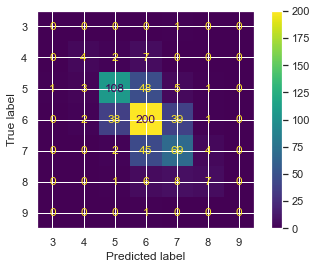

In [47]:
from sklearn.neural_network import MLPClassifier

#     grid_parameters = {
#         'hidden_layer_sizes': [(50,50), (100,50), (500,15), (100,)],
#         'activation': ['tanh', 'relu'],
#         'solver': ['sgd', 'adam'],
#         'alpha': 10.0 ** -np.arange(1, 10),
#         'learning_rate': ['adaptive'],
#         'max_iter': [5000]
#         }
# clf = GridSearchCV(MLPClassifier(), grid_parameters, n_jobs=-1, verbose=1)
# print(clf.best_params_)

best_params = {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (500, 15), 'learning_rate': 'adaptive', 'max_iter': 5000, 'solver': 'adam'}
clf = MLPClassifier(random_state=RANDOM_STATE, **best_params)

# original dataset
clf.fit(X_train_sc, y_train)
evaluate_cls(clf, X_train_sc, y_train, X_test_sc, y_test, verbose='maximal')

In [48]:
# Append results for MLP fit on each dataset 
res_list = add_cls_res('mlp', svc, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)

results_df = results_df.append(res_list)
print('MLP done')

--> All
Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training acc: 0.44
Test acc: 0.43
AUC non available
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        13
           5       0.58      0.41      0.48       166
           6       0.50      0.86      0.63       280
           7       1.00      0.00      0.00       120
           8       1.00      0.00      0.00        22
           9       1.00      0.00      0.00         1

    accuracy                           0.51       603
   macro avg       0.87      0.18      0.16       603
weighted avg       0.65      0.51      0.43       603

--> Oversample
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Training acc: 0.58
Test acc: 0.32
AUC non available
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.11      0.62      0.19        13
           5       0.50      0.45      0.47       166
     

/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training acc: 0.44
Test acc: 0.43
AUC non available
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        13
           5       0.58      0.42      0.49       166
           6       0.50      0.86      0.63       280
           7       1.00      0.00      0.00       120
           8       1.00      0.00      0.00        22
           9       1.00      0.00      0.00         1

    accuracy                           0.51       603
   macro avg       0.87      0.18      0.16       603
weighted avg       0.65      0.51      0.43       603

--> PCA
Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training acc: 0.42
Test acc: 0.40
AUC non available
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        13
           5       0.54      0.31      0.39       166
           6       0.48      0.88      0.62       280
           7       1.00      0.00      0.00       120
           8       1.00      0.00      0.00        22
           9       1.00      0.00      0.00         1

    accuracy                           0.49       603
   macro avg       0.86      0.17      0.15       603
weighted avg       0.63      0.49      0.40       603

MLP done


# XGBoost



/Users/bettyld/opt/anaconda3/envs/netsmile2/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training acc: 1.00
Test acc: 0.66
Roc AUC score 0.84
Precision-Recall AUC score 0.45
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.62      0.38      0.48        13
           5       0.72      0.62      0.66       166
           6       0.66      0.77      0.71       280
           7       0.59      0.57      0.58       120
           8       0.86      0.27      0.41        22
           9       1.00      0.00      0.00         1

    accuracy                           0.66       603
   macro avg       0.78      0.37      0.41       603
weighted avg       0.67      0.66      0.65       603



<AxesSubplot:>

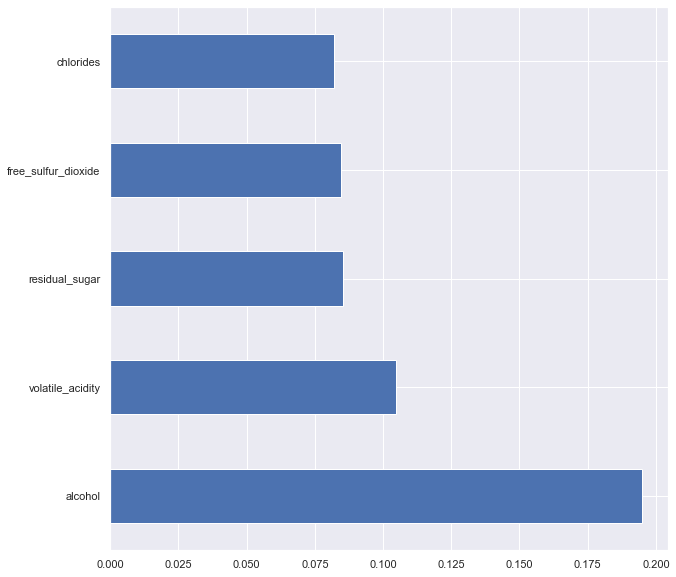

In [31]:
import xgboost as xgb

xgb_ = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgb_.fit(X_train_sc, y_train)
val_pred = xgb_.predict(X_val_sc)
evaluate_cls(xgb_, X_train_sc, y_train, X_test_sc, y_test, verbose='minimal')

feat_importances = pd.Series(xgb_.feature_importances_, index=feat_col)
feat_importances.nlargest(5).plot(kind='barh',figsize=(10,10))

In [51]:
# Append results for XGBoost fit on each dataset 
res_list = add_cls_res('xgboost', xgb_, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)
results_df = results_df.append(res_list)
print('XGBoost done')

--> All
[11:18:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training acc: 1.00
Test acc: 0.66
Roc AUC score 0.84
Precision-Recall AUC score 0.45
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.62      0.38      0.48        13
           5       0.72      0.62      0.66       166
           6       0.66      0.77      0.71       280
           7       0.59      0.57      0.58       120
           8       0.86      0.27      0.41        22
           9       1.00      0.00      0.00         1

    accuracy                           0.66       603
   macro avg       0.78      0.37      0.41       603
weighted avg       0.67      0.66      0.65       603

--> Oversample
[11:18:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training acc: 1.00
Test acc: 0.63
Roc AUC score 0.80
Precision-Recall AUC score 0.41
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.42      0.38      0.40        13
           5       0.70      0.58      0.64       166
           6       0.66      0.70      0.68       280
           7       0.55      0.64      0.59       120
           8       0.54      0.32      0.40        22
           9       1.00      0.00      0.00         1

    accuracy                           0.63       603
   macro avg       0.55      0.38      0.39       603
weighted avg       0.64      0.63      0.63       603

--> Preselected
[11:18:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training acc: 1.00
Test acc: 0.63
Roc AUC score 0.78
Precision-Recall AUC score 0.41
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.57      0.31      0.40        13
           5       0.69      0.58      0.63       166
           6       0.62      0.72      0.67       280
           7       0.56      0.56      0.56       120
           8       1.00      0.32      0.48        22
           9       1.00      0.00      0.00         1

    accuracy                           0.63       603
   macro avg       0.78      0.36      0.39       603
weighted avg       0.64      0.63      0.62       603

--> PCA
[11:18:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training acc: 1.00
Test acc: 0.67
Roc AUC score 0.85
Precision-Recall AUC score 0.44
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.15      0.27        13
           5       0.71      0.63      0.67       166
           6       0.64      0.80      0.72       280
           7       0.65      0.54      0.59       120
           8       1.00      0.27      0.43        22
           9       1.00      0.00      0.00         1

    accuracy                           0.67       603
   macro avg       0.86      0.34      0.38       603
weighted avg       0.69      0.67      0.65       603

XGBoost done


# Conclusion
## Best model

---> Random Forest. <br> 
---> XGBoost.

## Best dataset

---> Using all features.

## Best features
What features makes a wine being a good wine?
- high alcohol
- density             
- low volatile acidity      
- low free sulfur dioxide        

We could reduce the quality problem into a smaller classification problem wth the three classes {low, medium, high}. We won't implement it because we implement the binary classifier. 

In [52]:
# *_m is macro average
# *_w is weighted average
# auc is Area Under the Curve
# PR is Precision-Recall area

# Overview of the results
results_df.sort_values(by=['f1_m', 'f1_w', 'pr'], ascending=False)

method dataset      pr_m     rec_m      f1_m      pr_w     rec_w  \
0       rf     all  0.838725  0.365234  0.409635  0.699116  0.676617   
0  xgboost     all  0.777808  0.374383  0.406454  0.667637  0.660033   
1       rf      os  0.562954  0.395456  0.404941  0.663598  0.661692   
2       rf     pre  0.835148  0.357890  0.403232  0.688679  0.665008   
3       rf     pca  0.834338  0.350354  0.394287  0.697456  0.673300   
2  xgboost     pre  0.777495  0.356221  0.391856  0.640544  0.626866   
1  xgboost      os  0.551286  0.375543  0.386497  0.637508  0.633499   
3  xgboost     pca  0.858147  0.342617  0.381176  0.686173  0.666667   
1      svm      os  0.360375  0.277075  0.191475  0.451668  0.285240   
1      mlp      os  0.360375  0.277075  0.191475  0.451668  0.285240   
2       lr     pre  0.791456  0.195265  0.188781  0.548366  0.520730   
2   linreg     pre  0.788248  0.190937  0.187135  0.539775  0.500829   
0   linreg     all  0.784554  0.186804  0.182158  0.531333  0.490879   
1   linreg      os  0.172366  0.490171  0.181535  0.417522  0.343284   
0       lr     all  0.774628  0.188452  0.181199  0.521606  0.504146   
3       lr     pca  0.754290  0.173203  0.160192  0.485784  0.482587   
2      svm     pre  0.868604  0.182690  0.159801  0.651681  0.514096   
2      mlp     pre  0.868604  0.182690  0.159801  0.651681  0.514096   
0      svm     all  0.868448  0.181989  0.158917  0.651580  0.514096   
0      mlp     all  0.868448  0.181989  0.158917  0.651580  0.514096   
1       lr      os  0.194670  0.199152  0.151974  0.430831  0.238806   
3   linreg     pca  0.752029  0.161192  0.146691  0.474229  0.461028   
3      svm     pca  0.860836  0.169400  0.145126  0.634143  0.492537   
3      mlp     pca  0.860836  0.169400  0.145126  0.634143  0.492537   

       f1_w       auc        pr  
0  0.666192  0.806646  0.494444  
0  0.653117  0.836829  0.448535  
1  0.660463    0.8038  0.473183  
2  0.653354    0.8728  0.483665  
3  0.660230  0.811108  0.473829  
2  0.621399  0.779958  0.412831  
1  0.631205  0.802403  0.413765  
3  0.654708  0.849412  0.439645  
1  0.317848      None      None  
1  0.317848      None      None  
2  0.466688  0.754669  0.254794  
2  0.452114      None      None  
0  0.440467      None      None  
1  0.368715      None      None  
0  0.451612  0.756357  0.250578  
3  0.415768  0.730794  0.230173  
2  0.426875      None      None  
2  0.426875      None      None  
0  0.425693      None      None  
0  0.425693      None      None  
1  0.271790  0.723236  0.221557  
3  0.384423      None      None  
3  0.397552      None      None  
3  0.397552      None      None